# Plotting RBush

We want to see the structure of a RBush -- we want to plot the 2D spatial distribution of the items in a RBush tree.

We'll do that using [datashader][ds] and its companions, [xarray][xr], [bokeh][bk], [holoviews][hv], [pandas][pd], [numpy][np].

This exercise is based on:
* https://anaconda.org/jbednar/plotting_pitfalls/notebook
* https://anaconda.org/jbednar/pipeline/notebook

After a first approach, investigate/exercise the following:
* does bokeh-webgl engine support Rectangle glyph?


[ds]: http://datashader.readthedocs.io/
[xr]: http://xarray.pydata.org/
[bk]: https://bokeh.pydata.org
[hv]: http://holoviews.org/
[pd]: https://pandas.pydata.org/
[np]: http://www.numpy.org/

In [1]:
import datashader as ds
import xarray as xr
import bokeh as bk
import pandas as pd
import numpy as np

In [2]:
print(ds.__version__)
print(xr.__version__)
print(bk.__version__)
print(pd.__version__)
print(np.__version__)

0.6.2
0.10.0
0.12.13
0.20.3
1.13.1


[RBush](https://github.com/parietal-io/py-rbush)
```
rbush.__version__ : '0.0.2+9.g355496a'
```

In [3]:
import rbush

In [4]:
from rbush.data import generate_data_array

N = 1000

data = generate_data_array(N,10)

In [5]:
t = rbush.RBush()
t.load(data)

In [6]:
items = t.all()

# TODO: "retrieve-all" output should be an array (like the input 'data', apart from permutations)

bboxes = np.asarray([[i.xmin, i.ymin, i.xmax, i.ymax] for i in items])

In [7]:
# Apart from (raw) permutations, 'data' and 'bboxes' should contain the same information
assert data.shape==bboxes.shape

In [8]:
print(data.min(axis=0))
print(data.max(axis=0))
print(data.mean(axis=0))

[-226.96134082 -262.14969374 -216.96134082 -252.14969374]
[ 271.6729232   321.36839756  281.6729232   331.36839756]
[  6.02554248   1.90276096  16.02554248  11.90276096]


In [9]:
print(bboxes.min(axis=0))
print(bboxes.max(axis=0))
print(bboxes.mean(axis=0))

[-203.43923905 -226.87037457 -193.43923905 -216.87037457]
[ 68.13575451   3.5929943   78.13575451  13.5929943 ]
[-147.52302615 -151.24284665 -137.52302615 -141.24284665]


**We see now that BBush has a (big) bug!** To not deviate from our exercise, let's use the `data` array, it's the same structure (as `bboxes`)

Datashader works in a canvas represented by an `xarray` where each element is a bin.
The bin represents a pixel in a (data) coordinates system.
Each bin contains information aggregated from the dataset(s) at that (pixel) position.

Let's say we want to count the number of items (bounding-boxes in our dataset) that cover each position in the dataset parameters space (xmin,ymin,xmax,ymax) -- a heatmap of the items distribution.
Each bin in the datashader (xarray) canvas will contain the number counts.

As a first approach, let's do the representation of items' centroids.
Then we evolve to plotting the boxes' coverage area.

In [10]:
df = pd.DataFrame(data, columns=['xmin','ymin','xmax','ymax'])
df['x'] = df[['xmin','xmax']].mean(axis=1)
df['y'] = df[['ymin','ymax']].mean(axis=1)

In [11]:
df.describe()

,xmin,ymin,xmax,ymax,x,y
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,6.025542,1.902761,16.025542,11.902761,11.025542,6.902761
std,88.756705,90.262699,88.756705,90.262699,88.756705,90.262699
min,-226.961341,-262.149694,-216.961341,-252.149694,-221.961341,-257.149694
25%,-55.549499,-59.328102,-45.549499,-49.328102,-50.549499,-54.328102
50%,7.431992,3.535017,17.431992,13.535017,12.431992,8.535017
75%,65.384806,60.569098,75.384806,70.569098,70.384806,65.569098
max,271.672923,321.368398,281.672923,331.368398,276.672923,326.368398


In [12]:
# We will represent centroids

glyph = ds.glyphs.Point('x', 'y')

In [13]:
# Say we want to see in a resolution of "1 data-unit" of the (variable) data axes range
xres = 1
yres = 1

xlims = [int(df.xmin.min()), int(df.xmax.max()+1)]
ylims = [int(df.ymin.min()), int(df.ymax.max()+1)]

xsize = (xlims[1] - xlims[0])//xres
ysize = (ylims[1] - ylims[0])//yres

def def_pos2pix(pmin,res):
    pos_zero = int(pmin/res)
    def f(pos):
        return int(pos/res) - pos_zero
    return f

def def_pix2pos(pmin,res):
    def f(pix):
        return pix*res + pmin
    return f

pos2pix_x = def_pos2pix(xlims[0], xres)
pos2pix_y = def_pos2pix(ylims[0], yres)

pix2pos_x = def_pix2pos(xlims[0], xres)
pix2pos_y = def_pix2pos(ylims[0], yres)

In [14]:
canvas = ds.Canvas(plot_width=xsize, plot_height=ysize, x_range=xlims, y_range=ylims)

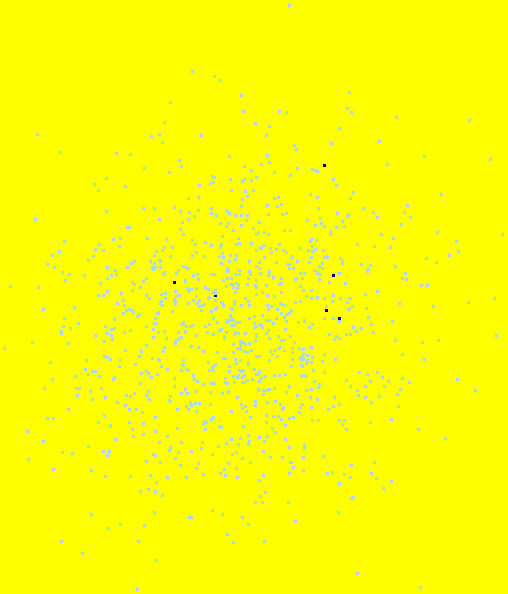

In [15]:
from datashader import transfer_functions as tf
from datashader import reductions

img = tf.shade(canvas.points(df,'x','y', agg=reductions.count()), how='eq_hist')
img = tf.spread(img, px=1, shape='square')
tf.set_background(img, 'yellow')

In [16]:
a = np.zeros((xsize,ysize),dtype=int)

for i in range(len(data)):
    row = data[i]
#     print(row)
    xi = pos2pix_x(row[0])
    xf = pos2pix_x(row[2])
    yi = pos2pix_y(row[1])
    yf = pos2pix_y(row[3])
#     print(xi,yi,xf,yf)
    x0 = pix2pos_x(xi)
    y0 = pix2pos_y(yi)
    a[xi:xf,yi:yf] += 1


In [17]:
# Let's build an xarray from 'a'
# xarray have a coordinates attribute ('coords'), apart from dimensions ('dims')

xaxis = np.arange(xlims[0], xlims[1], xres)
yaxis = np.arange(ylims[0], ylims[1], yres)
axx = xr.DataArray(a, dims=['x','y'], coords={'x':xaxis, 'y':yaxis})
axx

<xarray.DataArray (x: 508, y: 594)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x        (x) int64 -226 -225 -224 -223 -222 -221 -220 -219 -218 -217 ...
  * y        (y) int64 -262 -261 -260 -259 -258 -257 -256 -255 -254 -253 ...

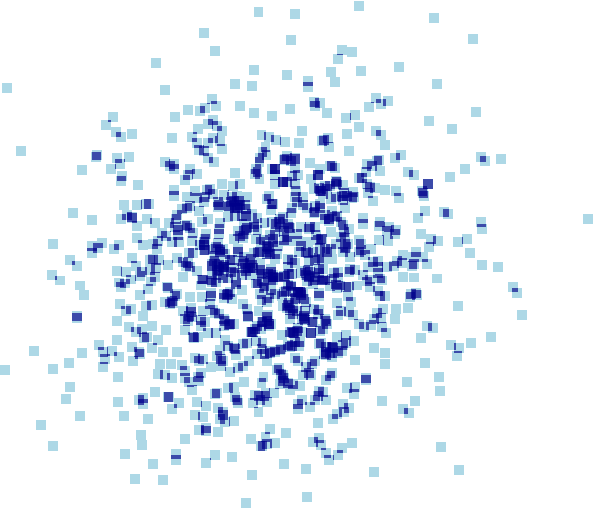

In [18]:
tf.shade(axx)

In [19]:
# dfa = pd.DataFrame(a).stack().rename_axis(['y', 'x']).reset_index(name='count')
# dfa['x'] = dfa['x'].apply(pix2pos_x)
# dfa['y'] = dfa['y'].apply(pix2pos_y)

# df.sort_values(['x', 'y'])[['x', 'y', 'count']].reset_index(drop=True)
# dfa = dfa.set_index(['x','y'])
# dfa